In [80]:
import pandas as pd

# Load tweets
df = pd.read_csv("Bitcoin_tweets.csv", parse_dates=['date'])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].dtype)  # should be datetime64[ns]

print(df['date'].isna().sum())
print(df['date'].min(), df['date'].max())


In [82]:
# Keep only the specified columns if they exist in the dataframe
columns_to_keep = ['user_created', 'user_followers', 'date', 'text']
df_filtered = df[columns_to_keep]
filters = {
    'user_created': lambda df: df['user_created'] < df['date'] - pd.Timedelta(days=30),
    'user_followers': lambda df: df['user_followers'] > 500
}

# Apply filters
for col, condition in filters.items():
    df = df[condition(df)]
    
df_filtered.to_csv("filtered_tweets.csv", index=False)
        

In [5]:
import re

def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"#", "", text)        # remove hashtag symbol
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_tweet)


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load FinBERT
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run on a sample
df['sentiment'] = df['clean_text'].apply(lambda x: finbert(x[:512])[0]['label'])  # truncate to 512 tokens


In [12]:
sentiment_score = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_score)

# Aggregate sentiment per day
daily_sentiment = df.groupby(df['date'].dt.date)['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['date', 'avg_sentiment']

daily_sentiment


In [8]:
import yfinance as yf

# Load BTC data from yfinance
btc = yf.download("BTC-USD", start="2021-01-01", end="2021-12-31")
btc = btc[['Close']].reset_index()
btc.columns = ['date', 'btc_close']

# Merge sentiment with price
btc['date'] = btc['date'].dt.date
merged = pd.merge(daily_sentiment, btc, on='date', how='inner')

# Calculate daily return
merged['btc_return'] = merged['btc_close'].pct_change()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


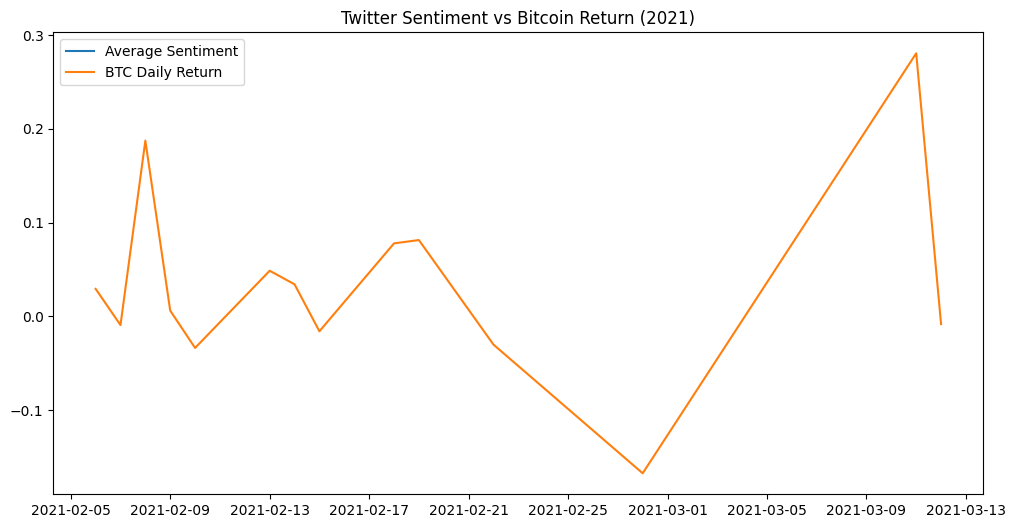

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged['date'], merged['avg_sentiment'], label='Average Sentiment')
plt.plot(merged['date'], merged['btc_return'], label='BTC Daily Return')
plt.legend()
plt.title("Twitter Sentiment vs Bitcoin Return (2021)")
plt.show()


In [10]:
correlation = merged[['avg_sentiment', 'btc_return']].corr().iloc[0,1]
print(f"Correlation between sentiment and return: {correlation:.4f}")


Correlation between sentiment and return: nan
